In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy import interpolate
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline,interp1d,splprep,splev
from scipy.signal import medfilt
from os import listdir,path,walk
import matplotlib as mpl
from scipy.signal import savgol_filter
import lmfit as lm
import scipy.stats as stats
import os
from scipy import interpolate
import subprocess
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.optimize import fsolve

colors = mpl.cm.get_cmap('coolwarm', 10)
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['axes.linewidth'] = 1.5
pd.options.display.float_format = '{:,.4f}'.format

mpl.rcParams['font.size']  = 40
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize']= 16
mpl.rcParams['ytick.labelsize']= 16
mpl.rcParams['legend.fontsize']= 14
mpl.rcParams['legend.title_fontsize']= 14

# Modeling: ExHOS kinetics

## Functions

In [9]:
#---------------------------------------------------------------------------------#
def p_c(t,k,f):
    if f == "Expon":
        return np.exp(-k*t)
    elif f == "Beta":
        return (1-t)**(k-1)
    if f == "Two_Expon":
        return ((np.exp(-k1*t) - np.exp(-k*t))*k1)/(k- k1) 
    else:
        print("Beta or Expon")
        return np.nan

def p_c_int(k,to,tf,f,shift=0):
    if f == "Expon":
        integral = 1/k*(np.exp(-to*k)-np.exp(-tf*k))
    elif f == "Two_Expon":
        integral = (-np.exp(-k1*tf)/k1 + np.exp(-k*tf)/k)*k1/(k - k1) -\
              (-np.exp(-k1*to)/k1 + np.exp(-k*to)/k)*k1/(k - k1)   
        #return ((np.exp(-k*tf) - np.exp(-k*to))*k1/k +\
        #        (-np.exp(-k1*tf) + np.exp(-k1*to))*k/k1 +\
        #        k1*tf - k*tf - k1*to + k*to)/(k1 - k)- shift
    elif f == "Beta":
        integral = 1/k*((1-to)**k-(1-tf)**k)  
    else:
        print("Beta or Expon")
        return np.nan    
    return integral - shift

def derivates_pc_t(var,tf,to,k,pc):
    if var == "k":
        return 1/(tf-to)*1/k * (tf*np.exp(-k*tf)-to*np.exp(-k*to)) - 1/k*pc
    elif var == "to":
        return -1/(tf-to)*pc + 1/(tf-to)*np.exp(-k*to)
    elif var == "tf":
        return 1/(tf-to)*pc - 1/(tf-to)*np.exp(-k*tf)
    else:
        print("var is 'k', 'tf' or 'to'")
        return np.nan

## Run

In [52]:
## Populations from  SMLM ###
pop_SMLM = pd.read_csv("Results_over_replicates_using_fixed_Class_Oct11_GitHub.csv")
pop_SMLM.index = ["Sec2","WT","Sec9","Sec18"]
pop_SMLM

,Set,Compact,Expanded,STD,SEM,Count,N_replicates
Sec2,Sec2_GFP,0.2654,0.7346,0.0313,0.0601,173,3
WT,WT,0.3243,0.6757,0.0348,0.0767,136,3
Sec9,Sec9_GFP,0.0898,0.9102,0.0187,0.0355,202,3
Sec18,Sec18_AA,0.0573,0.9427,0.0128,0.0348,220,3


In [53]:
timeline = pd.read_csv("Times.csv")
exodur   = 9.4
timeline["Dur_C1"]      = [exodur,9.4,exodur,exodur]
timeline["T_arrival"]  += timeline["Dur_C1"]
timeline["T_departure"]+= timeline["Dur_C1"]
timeline.index          = timeline["Protein"]
timeline.loc["WT"]      = ["WT",90,0,0,exodur,2.7,0,0,exodur]
timeline

,Protein,Count,T_arrival,SD_arrival,T_departure,SD_departure,Dur_C2,SD_Dur_C2,Dur_C1
Protein,,,,,,,,,
Sec2,Sec2,34,-0.0797,2.7249,8.6050,2.7763,8.6847,3.6154,9.4000
Sec9,Sec9,42,3.0949,2.6339,11.9006,1.2393,8.8057,3.1991,9.4000
Sec17,Sec17,21,8.8467,2.7125,14.4871,2.3719,5.6405,2.0829,9.4000
Sec18,Sec18,14,9.0986,1.6599,13.7271,1.1097,4.6286,2.0521,9.4000
WT,WT,90,0.0000,0.0000,9.4000,2.7000,0.0000,0.0000,9.4000


### Fig 4B: First-order reaction-like model [Compact] -> [Expanded]

In [58]:
#++++++++++++++Exponential model: Pc = exp(-k*t)++++++++++++++
#++++++++++++++ Pc(t) + Pe(t) = 1++++++++++++++
# The average Compact population oberserved in the time-window [to,tf] is given by
# Pc_avg(to,tf) = 1/(tf-to) * 1/k *[exp(-k*to)-exp(-k*tf)]
model   = pop_SMLM[["Compact"]].copy() ## Results from SMLM 
model.rename(columns={"Compact":"Raw"},inplace=True)

## Results from SMLM, corrected by acc and taking into account the non-classified data population 
acc = 0.9
model["Raw_Err"] = np.sqrt(0.03**2+acc*(1-acc)/200) ## 0.03 is the average STD Distal/Proximal population in experimental data

f = "Expon"

for ids in pop_SMLM.index:    
    dur = timeline.loc[ids,"Dur_C1"]
    to  = max(0,timeline.loc[ids,"T_arrival"])
    tf  = min(timeline.loc[ids,"T_departure"],dur)
    to /= dur
    tf /= dur   
    
    pc_experimental = model.loc[ids,"Raw"]
    k_expo= fsolve(p_c_int, x0 = 2.6, args=(to,tf,"Expon",pc_experimental))[0]
    model.loc[ids,"K_Rate_Adim"] = k_expo    
    model.loc[ids,"K_Rate"] = k_expo/dur    
    model.loc[ids,"Tau"] = 1/(k_expo/dur)    
        
for ids in model.index:        
    dur = timeline.loc[ids,"Dur_C1"]
    to  = max(0,timeline.loc[ids,"T_arrival"])
    tf  = min(timeline.loc[ids,"T_departure"],dur)
    to /= dur
    tf /= dur     

    k_avg = model["K_Rate_Adim"].mean()    
    pc_estimated = p_c_int(k_avg,to,tf,f)    
    model.loc[ids,"Prob_Estimated"] = pc_estimated

    k_avg =  model.loc["Sec2","K_Rate_Adim"]
    pc_estimated = p_c_int(k_avg,to,tf,f)    
    model.loc[ids,"Prob_Estimated_Using_Sec2"] = pc_estimated  
model

/home/jsortiz/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,Raw,Raw_Err,K_Rate_Adim,K_Rate,Tau,Prob_Estimated,Prob_Estimated_Using_Sec2
Sec2,0.2654,0.0367,3.6331,0.3865,2.5873,0.3022,0.2654
WT,0.3243,0.0367,2.9163,0.3102,3.2232,0.3065,0.2680
Sec9,0.0898,0.0367,3.3254,0.3538,2.8267,0.1007,0.0759
Sec18,0.0573,0.0367,2.6000,0.2766,3.6154,0.0015,0.0009


In [62]:
model["K_Rate_Err"] = model["K_Rate"].std(ddof=1) 
model

,Raw,Raw_Err,K_Rate_Adim,K_Rate,Tau,Prob_Estimated,Prob_Estimated_Using_Sec2,K_Rate_Err,Prob_Estimated_Err,Prob_Estimated_Using_Sec2_Err
Sec2,0.2654,0.0367,3.6331,0.3865,2.5873,0.3022,0.2654,0.0483,0.0542,0.0540
WT,0.3243,0.0367,2.9163,0.3102,3.2232,0.3065,0.2680,0.0483,0.0435,0.0415
Sec9,0.0898,0.0367,3.3254,0.3538,2.8267,0.1007,0.0759,0.0483,0.0318,0.0279
Sec18,0.0573,0.0367,2.6000,0.2766,3.6154,0.0015,0.0009,0.0483,0.0795,0.0483


In [63]:

for ids in model.index:    
    
    dur = timeline.loc[ids,"Dur_C1"]
    to  = max(0,timeline.loc[ids,"T_arrival"])
    tf  = min(timeline.loc[ids,"T_departure"],dur)      
    
    to_std = timeline.loc[ids,"SD_arrival"]   / np.sqrt(timeline.loc[ids,"Count"])
    tf_std = timeline.loc[ids,"SD_departure"] / np.sqrt(timeline.loc[ids,"Count"])
    
    ###-------------------------------------------------------------------------------------###
    ### Error associated to the k estimation using the using raw populations
    k      = model.loc[ids,"K_Rate"]
    pc     = model.loc[ids,"Raw"]
    pc_err = model.loc[ids,"Raw_Err"]
    model.loc[ids,"K_Rate_Err"] = np.sqrt(derivates_pc_t("to",to,tf,k,pc)**2 * to_std**2+\
                                               derivates_pc_t("tf",to,tf,k,pc)**2 * tf_std**2+\
                                                pc_err**2) 
    ###-------------------------------------------------------------------------------------###
    
    ###-------------------------------------------------------------------------------------###
    ### Error associated to the Estimated Population using the mean k    
    k      = model["K_Rate"].mean()    
    k_std  = model["K_Rate"].std(ddof=1)    
    pc     = model.loc[ids,"Prob_Estimated"]    
    model.loc[ids,"Prob_Estimated_Err"] = np.sqrt( derivates_pc_t("k",to,tf,k,pc)**2 * k_std**2 +\
                                            derivates_pc_t("to",to,tf,k,pc)**2 * to_std**2+\
                                            derivates_pc_t("tf",to,tf,k,pc)**2 * tf_std**2 ) 
    ###-------------------------------------------------------------------------------------###
    
    ###-------------------------------------------------------------------------------------###    
    ### Error associated to the Estimated Population using the Sec2 k and the raw populations
    k      = model.loc["Sec2","K_Rate"]    
    k_std  = model.loc["Sec2","K_Rate_Err"]
    pc     = model.loc[ids,"Prob_Estimated_Using_Sec2"]    
    model.loc[ids,"Prob_Estimated_Using_Sec2_Err"] = np.sqrt( derivates_pc_t("k",to,tf,k,pc)**2 * k_std**2 +\
                                            derivates_pc_t("to",to,tf,k,pc)**2 * to_std**2+\
                                            derivates_pc_t("tf",to,tf,k,pc)**2 * tf_std**2 )
    ###-------------------------------------------------------------------------------------###

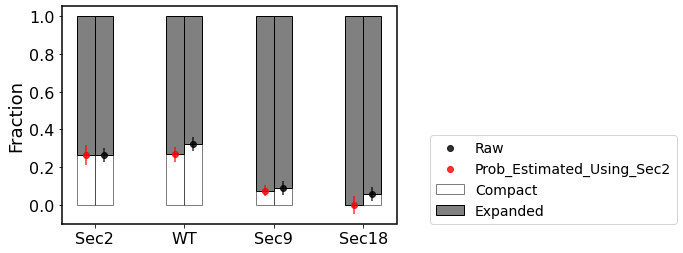

In [77]:
for i,s in enumerate(["Raw","Prob_Estimated_Using_Sec2"]):      

    plt.bar(np.arange(4)+0.1*(-1)**i, model[s].values,width=0.2,zorder=0,alpha=0.5,color='w',edgecolor='k',
            label="Compact" if s=="Raw" else None)
    plt.bar(np.arange(4)+0.1*(-1)**i, 1-model[s].values,bottom=model[s+corr].values,
            width=0.2,zorder=0,alpha=1.,color='gray',edgecolor='k',
           label="Expanded" if s=="Raw" else None)

    plt.scatter(np.arange(4)+0.1*(-1)**i, model[s].values,                          
         color = 'k' if s=="Raw" else 'r',alpha=0.8,zorder=0,label=s+corr)

    plt.errorbar(np.arange(4)+0.1*(-1)**i, model[s+corr].values,
         yerr = model[s+"_Err"],              
         color = 'k' if s=="Raw" else 'r',ls='',alpha=0.8,zorder=1)
plt.xticks(np.arange(4),model.index)  
plt.yticks(np.arange(0,1.1,0.2))
plt.legend(loc=[1.1,0])
plt.ylabel("Fraction")
#plt.savefig("../Figures/Two_States_model_predicted_populations_Using_Sec2%s.svg"%corr)
plt.show()

### Fig 4C: ExHOS kinetics model 

In [83]:
# ------------------------------------------------------------------------------------------------
# The ExHOS kinetics is modeled as 
# r_ExHOS (t) = mean_radius_Compact * P_c + mean_radius_Expanded * P_e (Equation 2)
# r_ExHOS (t) = mean_radius_Compact * P_c + mean_radius_Expanded * (1 - P_c)
# ------------------------------------------------------------------------------------------------
"""  Sec2_GFP        all 28.4 +- 19.3 --> 31.9
        WT        all 26.3 +- 18.5 --> 29.2
  Sec9_GFP        all 32.6 +- 19.5 --> 37.1
   Sec9_WT        all 26.4 +- 18.6 --> 29.3
"""
rcom = (22+15)/2
rexp = (28+50)/2
#model["R_mean_obs"] = [31.9,37.1,32.5,31.9]
model.loc[["Sec2","Sec9","WT","Sec18"],"R_Expanded" ]     = [36.3, 38.4, 34.2,39.2] #[37.3, 39.5, 36.0]
model.loc[["Sec2","Sec9","WT","Sec18"],"R_Expanded_Err" ] = [1.1, 0.8, 0.32,0.7]
model.loc[["Sec2","Sec9","WT","Sec18"],"R_Compact" ]      = [19.5, 24.1, 18.5,22.3]
model.loc[["Sec2","Sec9","WT","Sec18"],"R_Compact_Err" ]  = [2.0, 3.4, 5.4,0.8]

model.loc[["Sec2","Sec9","WT","Sec18"],"R_All"]      = [31.9, 37.1, 29.2,37.9]
model.loc[["Sec2","Sec9","WT","Sec18"],"R_All_Err"]  = np.sqrt(model["R_Compact_Err"]**2*model["Raw"]  +\
                                                    model["R_Expanded_Err"]**2*(1-model["Raw"]))

model["R_All_Avg"]       = model["R_Expanded"]*(1-model["Raw"]) + model["R_Compact"]*model["Raw"]
model["R_All_Avg_Err"]   = model["R_Expanded_Err"]**2*(1-model["Raw"]) + model["R_Compact_Err"]**2*model["Raw"]+\
                                model["R_Expanded_Err"]*model["Raw_Err"]**2 + model["R_Compact_Err"]*model["Raw_Err"]**2
model["R_All_Avg_Err"]   = np.sqrt(model["R_All_Avg_Err"]) 

model["R_All_Estimated"]     =  rexp + (rcom-rexp)*(model["Prob_Estimated_Using_Sec2"])
model["R_All_Estimated_Err"] = abs(rcom-rexp)*(model["Prob_Estimated_Using_Sec2_Err"])

Text(0, 0.5, 'Exocyst HOS radius (nm)')

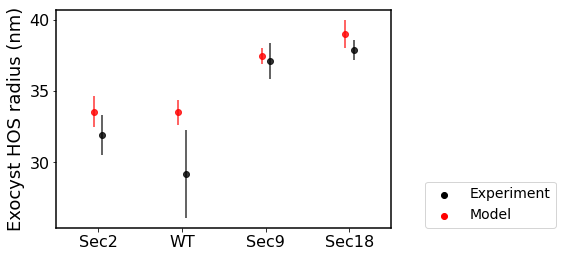

In [87]:
for i,s in enumerate(["","_Estimated"]):      
    plt.scatter(np.arange(4)+0.05*(-1)**i, model["R_All"+s].values,                          
         color = 'k' if s=="" else 'r',alpha=0.8,zorder=0,label=s+corr)

    plt.errorbar(np.arange(4)+0.05*(-1)**i, model["R_All"+s].values,
         yerr =  model["R_All"+s+"_Err"],              
         color = 'k' if s=="" else 'r',ls='',alpha=0.8,zorder=0)

plt.scatter(-1,30,color='k',label="Experiment")
plt.scatter(-1,30,color='r',label="Model")
plt.xlim(-.5,3.5)
plt.xticks(np.arange(4),model.index)        
plt.legend(loc=[1.1,0])
plt.ylabel("Exocyst HOS radius (nm)")
#plt.savefig("../Figures/Two_States_model_predicted_radii_Using_Sec2.svg")

In [91]:
# ------------------------------------------------------------------------------------------------
# Estimating the confidence intervals by randomizing k-values 
# ------------------------------------------------------------------------------------------------
t = np.arange(0,10,0.05)

y_avg2 = 1.*np.zeros_like(t)
y_avg  = 1.*np.zeros_like(t)
ky     = model.loc["Sec2","K_Rate"]
ky_err = model.loc["Sec2","K_Rate_Err"]
for trial in range(100):
    y  = rexp + (rcom-rexp)*np.exp(-np.random.normal(loc=ky,scale=ky_err)*t)
    y_avg2 += y** 2
    y_avg  += y 
    
y_avg  /= 100
y_avg2 /= 100
y_err   = np.sqrt(y_avg2-y_avg**2)

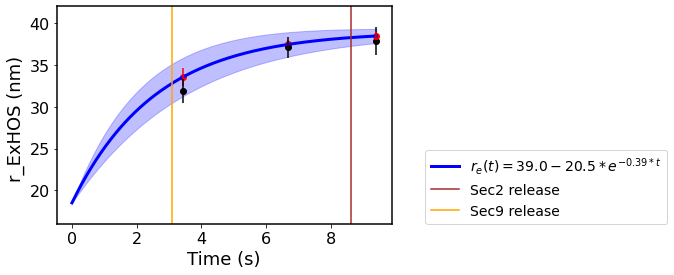

In [94]:
fig,ax2 = plt.subplots()
c  = 1 # 1 for std and 1.96 for 96% CI
c  = 1.96
ky    = model.loc["Sec2","K_Rate"+corr]
y     = rexp + (rcom-rexp)*np.exp(-ky*t)

sel   = t <= exodur
ax2.plot(t[sel],y[sel],label="$r_e(t) = %.1f - %.1f*e^{-%.2f*t}$"%(rexp,rexp-rcom,ky),lw=3,color='b')
ax2.fill_between(t[sel],y[sel]-c*y_err[sel],y[sel]+c*y_err[sel],alpha=0.25,color='b')



to = timeline.loc["Sec2","T_departure"]
ax2.axvline(to,label="Sec2 release",color='brown')
to = timeline.loc["Sec9","T_arrival"]
ax2.axvline(to,label="Sec9 release",color='orange')

for ids in ["Sec2","Sec9"]:
    yo  = model.loc[ids,"R_All_Estimated"]
    yo_err  = model.loc[ids,"R_All_Estimated_Err"]
    to  = 1/ky*np.log((rexp-rcom)/(rexp-yo))
    ax2.scatter(to,yo,color='r')
    ax2.errorbar(to,yo,yo_err,color='r')

    yo  = model.loc[ids,"R_All"]
    yo_err  = model.loc[ids,"R_All_Err"]
    ax2.scatter(to,yo,color='k')
    ax2.errorbar(to,yo,yo_err,color='k')
    
yo  = 37.9 ## Value of All Sec18_AA
yo_err  = np.sqrt(3.3**2*0.1+1.4**2*0.9) ## SEM for Comp. and Expand. Sec18AA
to  = 9.4
ax2.scatter(to,yo,color='k')
ax2.errorbar(to,yo,yo_err,color='k')
ax2.scatter(to,y[t==9.4],color='r')
ax2.errorbar(to,y[t==9.4],y_err[t==9.4],color='r')

ax2.set_ylim(16,42)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("r_ExHOS (nm) ")
ax2.legend(loc=[1.1,0])
#plt.savefig("../Figures/HOS_Radius"+corr+".svg")


# Modeling: Vesicle kinetics